In [ ]:
# PReface figure

In [1]:
import os

In [2]:
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
from xgcm import Grid
import glob

In [3]:
import matplotlib.dates as mdates
import datetime
import pandas as pd

In [4]:
%matplotlib inline

In [5]:
from matplotlib import rc
rc('font', **{'size':20})
rc('text', usetex=False)
rc('xtick', labelsize=20) #20 
rc('ytick', labelsize=20) #20
rc('axes', titlesize=20)    # fontsize of the axes title
rc('axes', labelsize=20) #24    # fontsize of the x and y labels

In [6]:
session=cc.database.create_session()
expt = '01deg_jra55v13_ryf9091'

In [7]:
from dask.distributed import Client

c=Client(local_directory = '/g/data/v45/qo9901/') 
c 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40287/status,
Dashboard: /proxy/40287/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43671,Workers: 2
Dashboard: /proxy/40287/status,Total threads: 2
Started: Just now,Total memory: 9.00 GiB
Comm: tcp://127.0.0.1:32839,Total threads: 1
Dashboard: /proxy/44753/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:40437,


In [ ]:
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

walltime = '01:00:00'
cores = 28

memory = '252GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),processes=cores,
                     job_extra=['-q normalbw','-P v45','-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/ik11+gdata/e14+gdata/hh5+gdata/v45+gdata/cj50',
                                '-l jobfs=400GB'],
                     local_directory='$TMPDIR',
                     header_skip=["select"],
                     #python=os.environ["DASK_PYTHON"]
                    )
cluster

# and if you want even more power, you can use this to make it three nodes
cluster.scale(jobs=1)

# then, run this to make a dask client

c = Client(cluster)
c

In [8]:
import gc
c.run(gc.collect)

{'tcp://127.0.0.1:32839': 56, 'tcp://127.0.0.1:41593': 56}

In [9]:
# location limits of dataset - choosing slice near totten
lon_lim = slice(-280, 79.99)#slice(30, 45)#
lat_lim = slice(-79,-60)#slice(-70, -65)

# time periods
flex_period = slice('2000','2010')#,'slice('2000', '2060')

In [10]:
v = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/v_daily_circ_ssh_lat7960_20002005yr_panan01.nc').isel(time = 100)

In [11]:
u = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/u_daily_circ_ssh_lat7960_20002005yr_panan01.nc').isel(time = 100)

In [12]:
u = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/u_daily_circ_ssh_lat7960_jupyter.nc').isel(time = 20)
v = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/v_daily_circ_ssh_lat7960_jupyter.nc').isel(time = 20)

In [13]:
u

<xarray.Dataset> Size: 25MB
Dimensions:   (xu_ocean: 3600, yu_ocean: 440)
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
    geolon_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 3600), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 3600), meta=np.ndarray>
    time      object 8B 2000-01-21 12:00:00
Data variables:
    ug_s      (yu_ocean, xu_ocean) float64 13MB dask.array<chunksize=(440, 3600), meta=np.ndarray>

In [14]:
speed = np.sqrt(u.ug_s**2 + v.vg_s**2).load()
speed

<xarray.DataArray (yu_ocean: 440, xu_ocean: 3600)> Size: 13MB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.04848625, 0.04914166, 0.05036705, ..., 0.07075659, 0.0595395 ,
        0.05268334],
       [0.03400423, 0.03674862, 0.03804948, ..., 0.05437541, 0.04173958,
        0.03595769],
       [0.0147927 , 0.02251536, 0.02031277, ..., 0.03099941, 0.01573084,
        0.        ]])
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
    geolon_c  (yu_ocean, xu_ocean) float32 6MB nan nan nan ... 79.8 79.9 80.0
    geolat_c  (yu_ocean, xu_ocean) float32 6MB nan nan nan ... -60.02 -60.02
    time      object 8B 2000-01-21 12:00:00

In [15]:
deptho = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='hu', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1)#.sel(yu_ocean = slice(-70,-50))
#deptho = cc.querying.getvar(expt=expt, variable='deptho', 
#                          session=session, frequency='static',
#                          attrs={'cell_methods': 'area:mean yh:mean xh:mean time: point'}, n=1)#.sel(yu_ocean = slice(-70,-50))

In [16]:
deptho_region = deptho.sel(yu_ocean = slice(-90,-60), xu_ocean = lon_lim)
deptho_region

<xarray.DataArray 'hu' (yu_ocean: 490, xu_ocean: 3599)> Size: 7MB
dask.array<getitem, shape=(490, 3599), dtype=float32, chunksize=(490, 900), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.7 79.8 79.9
  * yu_ocean  (yu_ocean) float64 4kB -81.09 -81.05 -81.0 ... -60.07 -60.02
    geolon_c  (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(490, 900), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(490, 900), meta=np.ndarray>
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    ncfiles:       ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf909...
    contact:       Andy Hogg
    email:         andy.hogg@anu.edu.au
    created:       2020-06-11
    description:   0.1 degree ACCESS-OM2 global model configuration with JRA5...
    notes:         Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1...
    url:           https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra55...

In [17]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [18]:
deptho_region

<xarray.DataArray 'hu' (yu_ocean: 490, xu_ocean: 3599)> Size: 7MB
dask.array<getitem, shape=(490, 3599), dtype=float32, chunksize=(490, 900), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.7 79.8 79.9
  * yu_ocean  (yu_ocean) float64 4kB -81.09 -81.05 -81.0 ... -60.07 -60.02
    geolon_c  (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(490, 900), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(490, 900), meta=np.ndarray>
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    ncfiles:       ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf909...
    contact:       Andy Hogg
    email:         andy.hogg@anu.edu.au
    created:       2020-06-11
    description:   0.1 degree ACCESS-OM2 global model configuration with JRA5...
    notes:         Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1...
    url:           https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra55...

In [19]:
#Create a land mask for plotting, set land cells to 1 and rest to NaN
land = xr.where(np.isnan(deptho_region.rename('land')), 1, np.nan)

In [20]:
import matplotlib
colorsList_no3 = [('mediumseagreen'),('tomato'),('blueviolet')]
CustomCmap_no3 = matplotlib.colors.ListedColormap(colorsList_no3)


In [21]:
clustering_mask = xr.open_mfdataset('/g/data/v45/txs156/ASC_classification/clustering_mask_time_mean.nc')

In [22]:
clustering_mask_sum = xr.concat([clustering_mask.regimes_mask.isel(regime = reg_no) * (reg_no+1) for reg_no in range(3)], dim = 'regime').sum(dim = 'regime')

In [23]:
import cmocean

In [24]:
## plotting everything together
cluster_mask_access = xr.open_mfdataset('Antarctic-Eddy-Res-Compare/largest_3cluster_mask_xr_accessom201.nc')
cluster_mask_access= cluster_mask_access.assign_coords(xu_ocean = ('xu_ocean', u.xu_ocean.data), yu_ocean = ('yu_ocean', v.yu_ocean.data))

In [25]:
def changeline_cs(linestyle):
    cs.monochrome = True
    for col,  ls in zip(cs.collections,cs._process_linestyles(linestyle)):
        col.set_linestyle(ls)
        col.set_edgecolor('k')
        

In [26]:
land

<xarray.DataArray 'land' (yu_ocean: 490, xu_ocean: 3599)> Size: 14MB
dask.array<where, shape=(490, 3599), dtype=float64, chunksize=(490, 900), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.7 79.8 79.9
  * yu_ocean  (yu_ocean) float64 4kB -81.09 -81.05 -81.0 ... -60.07 -60.02
    geolon_c  (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(490, 900), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 7MB dask.array<chunksize=(490, 900), meta=np.ndarray>

In [27]:
from matplotlib.patches import Patch

  for col,  ls in zip(cs.collections,cs._process_linestyles(linestyle)):



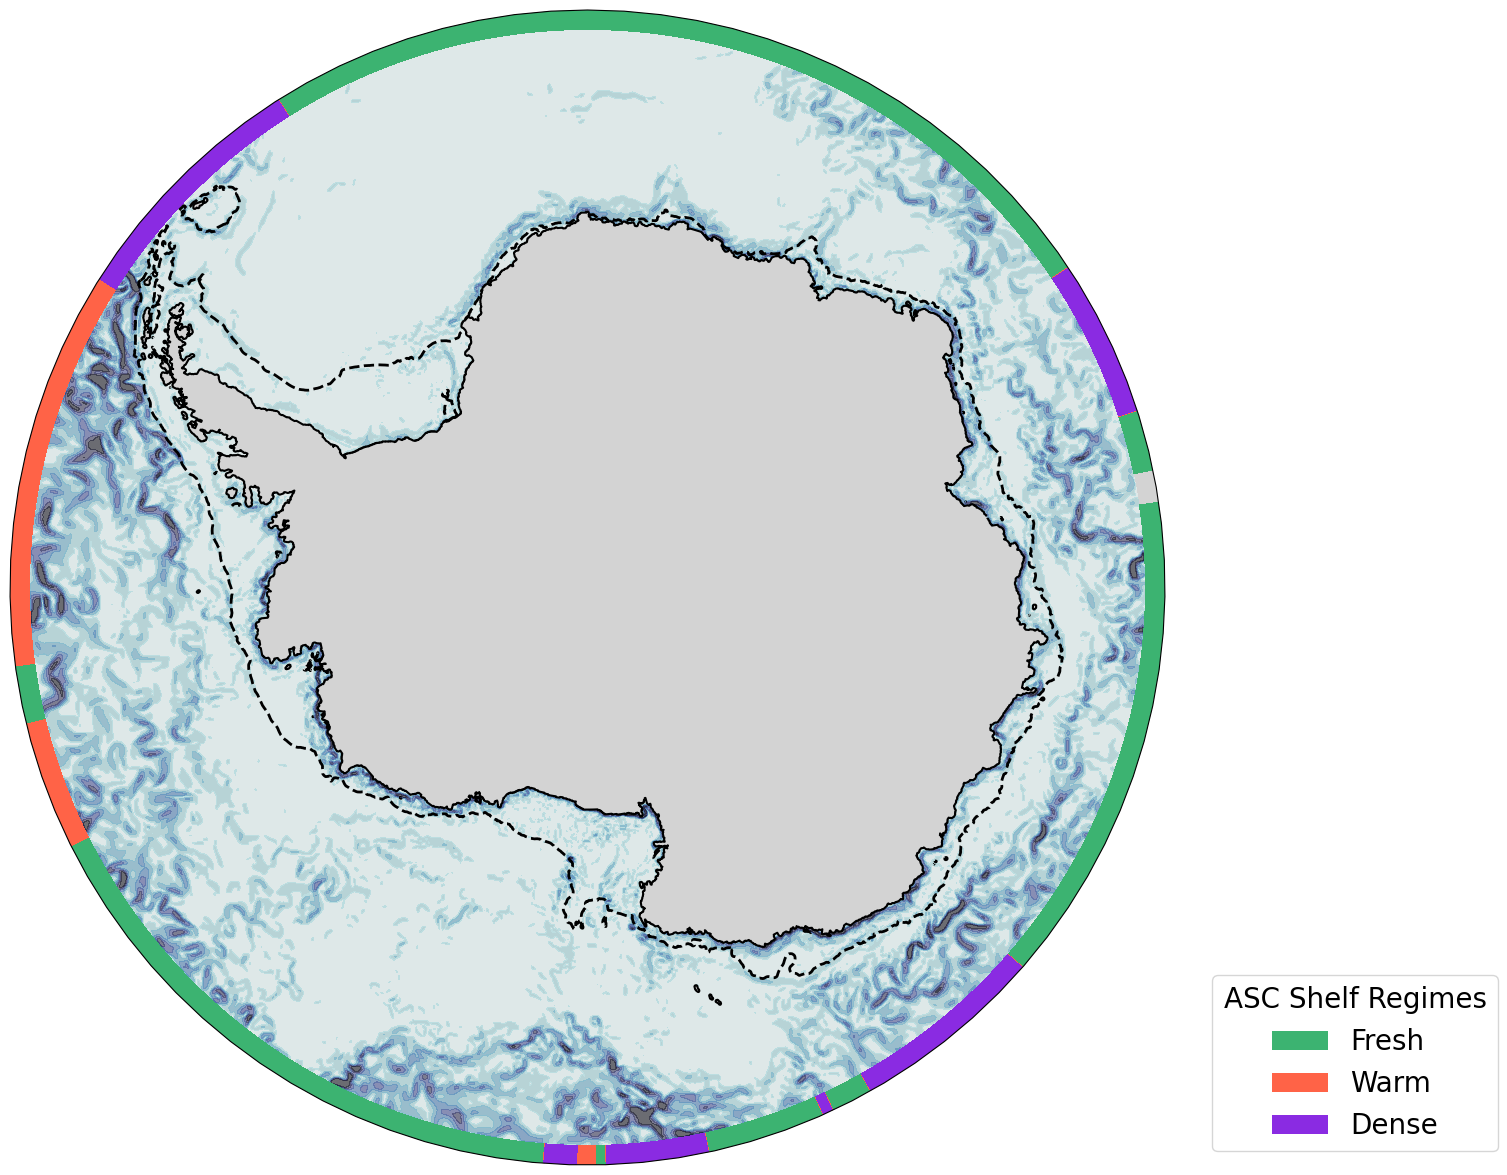

In [143]:
fig = plt.figure(1, figsize=(15, 15))

ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo(), facecolor='lightgrey')
ax.set_boundary(circle, transform=ax.transAxes)
    
# Filled land 
land.plot.contourf(ax=ax, colors='lightgrey', zorder=2,
                   transform=ccrs.PlateCarree(), add_colorbar=False)

# Coastline
land.fillna(0).plot.contour(ax=ax, colors='k', levels=[0, 1],
                            transform=ccrs.PlateCarree(), add_colorbar=False)

# Depth contours
cs =deptho_region.where(cluster_mask_access == True).__xarray_dataarray_variable__.plot.contour(ax=ax, levels=[1000],
                linewidths= 2, 
                transform=ccrs.PlateCarree())
changeline_cs('dashed')

#.where(cluster_mask_access == True).__xarray_dataarray_variable__
speed.plot.contourf(ax = ax, vmax = 0.3,
                    transform=ccrs.PlateCarree(), cmap = cmocean.cm.ice_r,alpha = 0.5, add_colorbar = False)                                      
ax.contourf(clustering_mask.lon, [-60,-59],  np.vstack((clustering_mask_sum,clustering_mask_sum)) ,
            transform=ccrs.PlateCarree(), cmap=CustomCmap_no3)
ax.set_title('')

legend_elem = [ Patch(facecolor=colorsList_no3[0], label='Fresh'), 
               Patch(facecolor=colorsList_no3[1], label='Warm'),
               Patch(facecolor=colorsList_no3[2], label='Dense')]
ax.legend(handles=legend_elem, loc='lower right', title = 'ASC Shelf Regimes', bbox_to_anchor=(1.3, 0))

  for col,  ls in zip(cs.collections,cs._process_linestyles(linestyle)):



Text(0.5, 1.0, '')

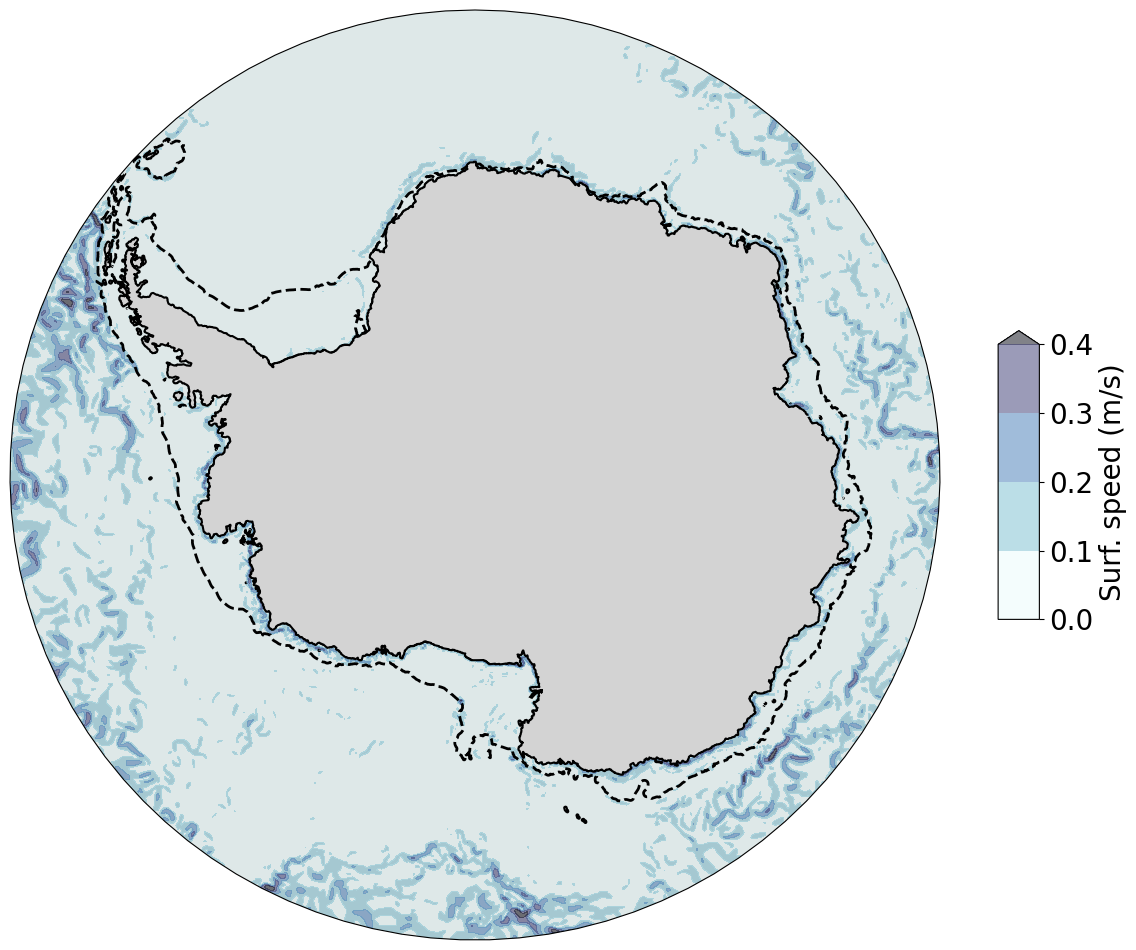

In [34]:
fig = plt.figure(1, figsize=(15, 15))

ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo(), facecolor='lightgrey')
ax.set_boundary(circle, transform=ax.transAxes)
    
# Filled land 
land.plot.contourf(ax=ax, colors='lightgrey', zorder=2,
                   transform=ccrs.PlateCarree(), add_colorbar=False)

# Coastline
land.fillna(0).plot.contour(ax=ax, colors='k', levels=[0, 1],
                            transform=ccrs.PlateCarree(), add_colorbar=False)

# Depth contours
cs =deptho_region.where(cluster_mask_access == True).__xarray_dataarray_variable__.plot.contour(ax=ax, levels=[1000],
                linewidths= 2, 
                transform=ccrs.PlateCarree())
changeline_cs('dashed')

#.where(cluster_mask_access == True).__xarray_dataarray_variable__
speed.plot.contourf(ax = ax, vmax = 0.5, levels = np.arange(0,0.5,0.1),
                    transform=ccrs.PlateCarree(), cmap = cmocean.cm.ice_r,alpha = 0.5, 
                   cbar_kwargs={'orientation': 'vertical',
                                                      'shrink': 0.25,
                                                      'extend': 'both',
                                                      'label': 'Surf. speed (m/s)',
                                                      'aspect': 7})                                      

ax.set_title('')
